In [1]:
"""Plots the loss of the model & performs basic evaluation.
"""

'Plots the loss of the model & performs basic evaluation.\n'

In [8]:
import pathlib
import torch
from typing import List, Union, Tuple
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from dataset import SimulationDataset
from model import MLPReg

In [9]:
def plot_loss(
    model_name: str, train_loss: List[float], valid_loss: List[float]
) -> None:
    """Visualizes the loss data of the trained model.

    Args:
        model_name: Name of the trained model.
        train_loss: Loss data generated during training.
        valid_loss: Loss data generated during validation.
    """
    plt.figure(figsize=(12, 7))
    plt.suptitle(model_name + " loss values")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.legend(["Training Loss", "Validation Loss"])
    plt.show()

In [10]:
def txt_to_list(input_path: Union[pathlib.Path, str]) -> List[str]:
    """Loads a .txt file into a list.
    Args:
        input_path: Input path to the txt file.

    Returns:
        List containing data from the .txt file.
    """
    with open(input_path, "r") as f:
        data = f.read().splitlines()
    
    return data

In [11]:
model_name = 'lr_1_e_m4_b_8_e_10000_transformed'

In [12]:
TRAINED_MODEL_PATH = f'./trained_models/{model_name}.pt'
TRAIN_LOSS_PATH = f'./trained_models/{model_name}_training_loss.txt'
VALID_LOSS_PATH = f'./trained_models/{model_name}_validation_loss.txt'

In [13]:
model_name = pathlib.Path(TRAINED_MODEL_PATH).stem
train_loss= txt_to_list(TRAIN_LOSS_PATH)
valid_loss= txt_to_list(VALID_LOSS_PATH)

In [14]:
# Convert str to float & tidy up.
train_loss = [float(el) for el in train_loss]
train_loss = [round(el, 4) for el in train_loss]

valid_loss = [float(el) for el in valid_loss]
valid_loss = [round(el, 4) for el in valid_loss]

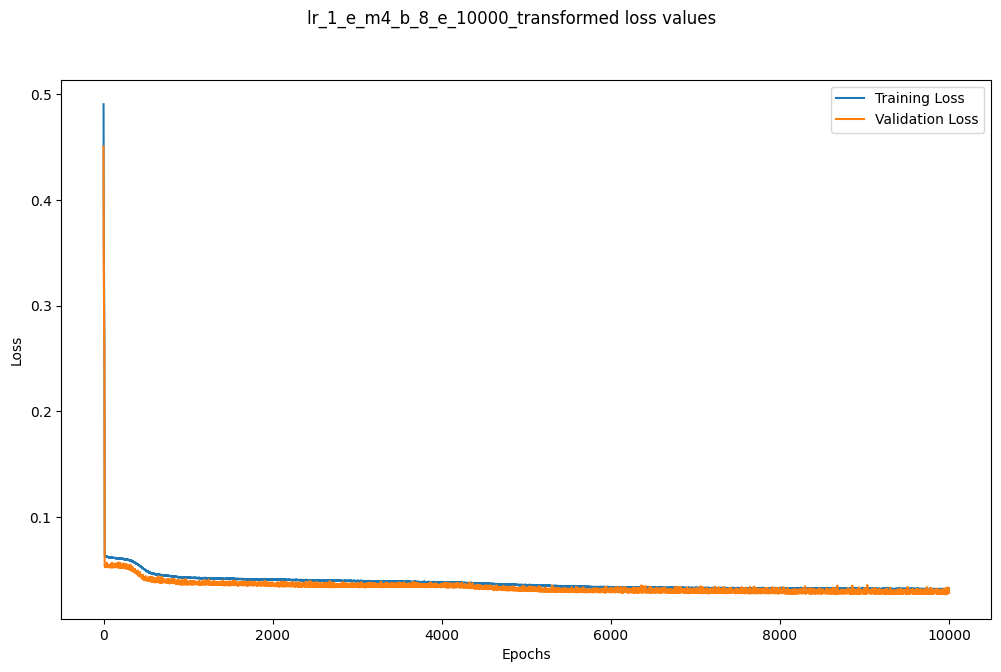

In [15]:
plot_loss(model_name, train_loss, valid_loss)

In [16]:
TRAINED_STATE_DICT_PATH = f'./trained_models/{model_name}_state_dict'

In [17]:
# Set the device & clean the memory.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
torch.cuda.empty_cache()

Device:  cuda:0


In [19]:
# Load the trained model state dictionary.
model = MLPReg()
model.load_state_dict(torch.load(TRAINED_STATE_DICT_PATH))

/tmp/ipykernel_264045/1831910469.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(TRAINED_STATE_DICT_PATH))


<All keys matched successfully>

In [22]:
# Load test dataset.
batch_size = 8
dataset_path = "./data/dataset_test.csv"
features = ["Temperature", "Depth Of Cut", "Feed Rate", "Lenght Of Cut"]
labels = ["Load X", "Load Y"]

test_dataset = SimulationDataset(dataset_path, features, labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [23]:
# Pre - normalization min and max values of output variables.
x_load_min = 49.78
x_load_max = 998679
y_load_min = 0.782819
y_load_max = 999488

In [29]:
# Evaluate the model.
generalization_errors_x = []
generalization_errors_y = []
for batch_features, batch_labels in test_dataloader:
    outputs = model(batch_features)
    predicted_labels = outputs.detach().numpy()

    for i in range(len(batch_features)):
        features = batch_features[i]
        labels = batch_labels[i]
        predicted = predicted_labels[i]

        print("Features:")
        print(features.numpy())

        print("Predicted Labels:")
        # Scale the predictions and ground truth labels back to nominal range.
        x_load_pred = predicted[0] * (x_load_max - x_load_min) + x_load_min
        y_load_pred = predicted[1] * (y_load_max - y_load_min) + y_load_min
        print("Predicted X Load:,", x_load_pred)
        print("Predicted Y Load:,", y_load_pred)

        print("Actual Labels:")
        x_load_actual = labels.numpy()[0] * (x_load_max - x_load_min) + x_load_min
        y_load_actual = labels.numpy()[1] * (y_load_max - y_load_min) + y_load_min
        print("Actual X Load:,", x_load_actual)
        print("Actual Y Load:,", y_load_actual)

        generalization_error_x = round(abs(x_load_pred - x_load_actual), 4)
        generalization_error_y = round(abs(y_load_pred - y_load_actual), 4)
        print('Error X:', generalization_error_x)
        print('Error Y:', generalization_error_y)
        generalization_errors_x.append(generalization_error_x)
        generalization_errors_y.append(generalization_error_y)

        print("------------------")

Features:
[0.44799027 0.2        0.2        1.5       ]
Predicted Labels:
Predicted X Load:, 426978.1558636612
Predicted Y Load:, 352844.0619343804
Actual Labels:
Actual X Load:, 75696.00371173813
Actual Y Load:, 238771.99975247442
Error X: 351282.1522
Error Y: 114072.0622
------------------
Features:
[0.57313603 0.4        0.15       1.5       ]
Predicted Labels:
Predicted X Load:, 213969.46722957163
Predicted Y Load:, 876066.0539610775
Actual Labels:
Actual X Load:, 208388.99816247702
Actual Y Load:, 754608.027061158
Error X: 5580.4691
Error Y: 121458.0269
------------------
Features:
[0.46633855 0.2        0.2        1.5       ]
Predicted Labels:
Predicted X Load:, 149121.0396359357
Predicted Y Load:, 424669.8500049613
Actual Labels:
Actual X Load:, 159174.00288571118
Actual Y Load:, 512762.99608122447
Error X: 10052.9632
Error Y: 88093.1461
------------------
Features:
[0.5638738 0.3       0.2       1.5      ]
Predicted Labels:
Predicted X Load:, 233307.71149223385
Predicted Y Load

In [25]:
generalization_errors_x = np.array(generalization_errors_x)
mae_x = np.sum(generalization_errors_x / np.shape(generalization_errors_x)[0])
mse_x = np.sum(generalization_errors_x**2 / np.shape(generalization_errors_x)[0])
rmse_x = np.sqrt(mse_x)

generalization_errors_y = np.array(generalization_errors_y)
mae_y = np.sum(generalization_errors_y / np.shape(generalization_errors_y)[0])
mse_y = np.sum(generalization_errors_y**2 / np.shape(generalization_errors_y)[0])
rmse_y = np.sqrt(mse_y)

In [30]:
print('Total evaluation metrics - Load X')
print('MAE:', np.round(mae_x, 4))
print('MSE:', np.round(mse_x, 4))
print('RMSE:', np.round(rmse_x, 4))
print('Total evaluation metrics - Load Y')
print('MAE:', np.round(mae_y, 4))
print('MSE:', np.round(mse_y, 4))
print('RMSE:', np.round(rmse_y, 4))

Total evaluation metrics - Load X
MAE: 84569.2332
MSE: 24451447962.155
RMSE: 156369.5877
Total evaluation metrics - Load Y
MAE: 109171.3653
MSE: 29065217917.1939
RMSE: 170485.2425
